In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [2]:
# 1. DATA LOADING & CLEANING

file_path = "heart_disease.xlsx"
# Fix: Specify sheet_name to ensure we load the data, not the description
df = pd.read_excel(file_path, sheet_name='Heart_disease')

# Standardize Column Names
df.columns = df.columns.astype(str).str.strip().str.replace(' ', '_').str.upper()

for col in df.columns:
    if df[col].dtype == 'object' or df[col].dtype == 'bool':
        df[col] = df[col].astype(str).str.upper() # Make everything uppercase string
        
        # Optional: Fix specific data entry typo found in EXANG
        df[col] = df[col].replace('TURE', 'TRUE')

print("Columns found:", df.columns.tolist())

Columns found: ['AGE', 'SEX', 'CP', 'TRESTBPS', 'CHOL', 'FBS', 'RESTECG', 'THALCH', 'EXANG', 'OLDPEAK', 'SLOPE', 'THAL', 'NUM']


In [3]:
# 2. MISSING VALUE IMPUTATION

# Re-identify types after conversion
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

# Impute Numeric
for col in numeric_cols:
    if df[col].isnull().sum() > 0:
        df[col] = df[col].fillna(df[col].median())

# Impute Categorical
for col in categorical_cols:
    if df[col].isnull().sum() > 0:
        df[col] = df[col].fillna(df[col].mode()[0])

In [4]:
# 3. PREPROCESSING & TRAINING

target_col = 'NUM'
X = df.drop(columns=[target_col])
y = df[target_col]

# Select columns for pipeline
X_num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
X_cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"Categorical features to encode: {X_cat_cols}")

# Transformers
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, X_num_cols),
        ('cat', categorical_transformer, X_cat_cols)
    ])

# Pipeline
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=42))
])

# Train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("\nTraining Decision Tree...")
clf.fit(X_train, y_train)

Categorical features to encode: ['SEX', 'CP', 'FBS', 'RESTECG', 'EXANG', 'SLOPE', 'THAL']

Training Decision Tree...


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['AGE', 'TRESTBPS', 'CHOL',
                                                   'THALCH', 'OLDPEAK']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['SEX', 'CP', 'FBS',
                                                   'RESTECG', 'EXANG', 'SLOPE',
                                                   'THAL'])])),
                ('classifier',
                 DecisionTreeClassifier(criterion='entropy', max_depth=5,
                                        random_state=42))])


--- Model Evaluation ---
Accuracy: 0.554945054945055

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.84      0.77        89
           1       0.38      0.54      0.45        48
           2       0.00      0.00      0.00        22
           3       0.00      0.00      0.00        17
           4       0.00      0.00      0.00         6

    accuracy                           0.55       182
   macro avg       0.22      0.28      0.24       182
weighted avg       0.45      0.55      0.50       182



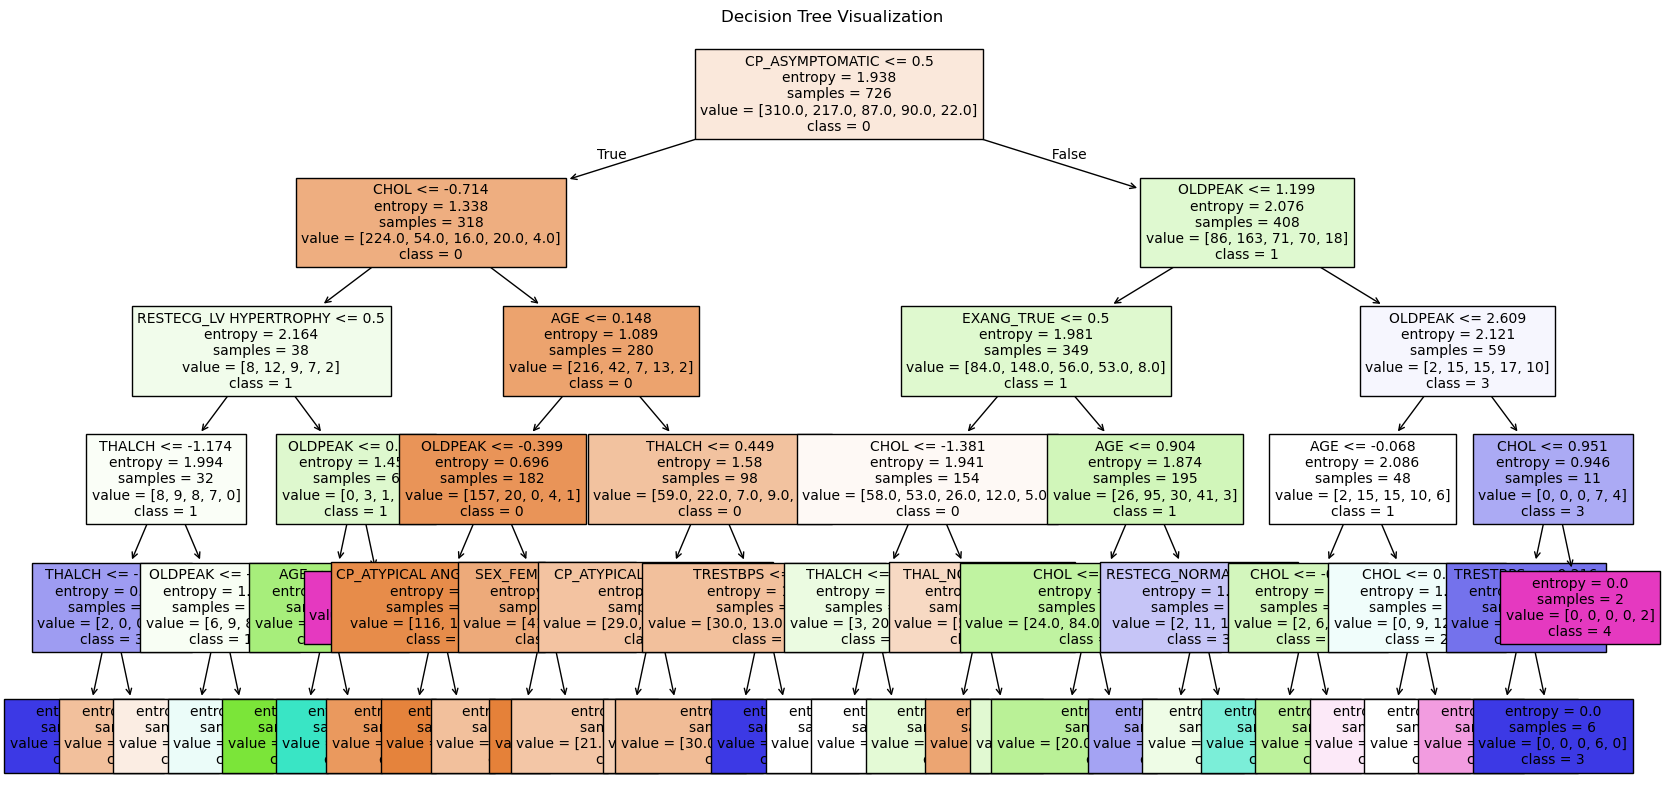

In [5]:
# 4. EVALUATION

y_pred = clf.predict(X_test)

print("\n--- Model Evaluation ---")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Plot Tree
plt.figure(figsize=(20, 10))
feature_names = (X_num_cols + 
                 list(clf.named_steps['preprocessor']
                      .named_transformers_['cat']
                      .named_steps['onehot']
                      .get_feature_names_out(X_cat_cols)))

plot_tree(clf.named_steps['classifier'], 
          feature_names=feature_names, 
          filled=True, 
          class_names=[str(i) for i in sorted(y.unique())],
          fontsize=10)
plt.title("Decision Tree Visualization")
plt.show()

In [6]:
# Interview Questions:

In [8]:
# 1.What are some common hyperparameters of decision tree models, and how do they affect the model's performance?
# Common Hyperparameters of Decision Tree Models and Their Impact

# 1.max_depth
# Defines the maximum depth of the tree.
# Smaller value → simpler tree, less overfitting, higher bias
# Larger value → complex tree, higher overfitting, lower bias

# 2.min_samples_split
# Minimum number of samples required to split an internal node.
# Higher value → prevents deep splits, reduces overfitting
# Lower value → allows more splits, may overfit

# 3.min_samples_leaf
# Minimum number of samples required at a leaf node.
# Higher value → smoother predictions, better generalization
# Lower value → more specific rules, higher variance

# 4.max_features
# Number of features considered when looking for the best split.
# Smaller value → more randomness, reduces overfitting
# Larger value → more accurate splits, may overfit

# 5.criterion
# Metric used to measure quality of a split (e.g., Gini, Entropy, MSE).
# Determines how impurity or error is calculated
# Affects split decisions and tree structure

# 6.max_leaf_nodes
# Maximum number of leaf nodes in the tree.
# Limits model complexity
# Helps control overfitting

# 7.min_impurity_decrease
# Minimum impurity reduction required for a split.
# Prevents unnecessary splits
# Produces a simpler and more robust tree

# Effect on Model Performance:
# These hyperparameters control the bias–variance tradeoff. Proper tuning helps balance underfitting and overfitting, 
# improves generalization, and increases model stability.

In [9]:
# # 2.What is the difference between the Label encoding and One-hot encoding?
# 1.Label Encoding:
# Label encoding converts categorical values into numeric labels by assigning each unique category an integer value.

# Example:
# Color = {Red, Green, Blue}
# Encoded as: Red = 0, Green = 1, Blue = 2

# Key characteristics:
# Uses a single column
# Introduces an ordinal relationship
# Simple and memory-efficient

# Best used when:
# Categories have a natural order (e.g., Low, Medium, High)
# Tree-based models (Decision Trees, Random Forests)

# Limitation:
# Can mislead models into assuming a ranking where none exists.

# One-Hot Encoding:
# One-hot encoding converts each category into a separate binary column (0 or 1).

# 2.One-Hot Encoding:
# One-hot encoding converts each category into a separate binary column (0 or 1).

# Example:
# Color = {Red, Green, Blue}

# Key characteristics:
# No ordinal relationship
# Preserves categorical independence
# Increases dimensionality

# Best used when:
# Categories are nominal (no order)
# Linear models, logistic regression, neural networks

# Limitation:
# Can lead to high dimensionality with many categories.